In [2]:
import findspark
findspark.init()

In [4]:
############################TASK 1####################################################

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, IntegerType, FloatType
spark = SparkSession.builder.getOrCreate()

#creating schema
ratingSchema = StructType([
    StructField("userID", IntegerType(), nullable=False),
    StructField("FilmID", IntegerType(), nullable=False),
    StructField("rating_value", FloatType(), nullable=False)
])

trustSchema = StructType([
    StructField("Trustor", IntegerType(), nullable=False),
    StructField("Trustee", IntegerType(), nullable=False),
    StructField("Trust_Value", FloatType(), nullable=False)
])

#loading data set and printing out
ratingsDF = spark.read.csv("ratings.txt", schema=ratingSchema, header=False, sep=' ')
ratingsDF.show()
ratingCount = ratingsDF.count()

trustDF = spark.read.csv("trust.txt", schema=trustSchema, header=False, sep=' ')
trustDF.show()
trustCount = trustDF.count()

print(ratingCount, trustCount)

#calculating counts after removing records with null values
ratingsDF = ratingsDF.dropna()
ratingAfterNullRemoved = ratingsDF.count()
trustDF = trustDF.dropna()
trustAfterNullRemoved = trustDF.count()
print("Original ratings count: ", ratingCount)
print("New ratings count after removing nulls: ", ratingAfterNullRemoved)
print("Original trust count: ", trustCount)
print("New trust count after removing nulls: ", trustAfterNullRemoved)

#calculating counts after removing records that are duplicates
ratingsDF = ratingsDF.dropDuplicates()
ratingAfterDuplicate = ratingsDF.count()
ratingDiff = ratingAfterNullRemoved - ratingAfterDuplicate
trustDF = trustDF.dropDuplicates()
trustAfterDuplicate = trustDF.count()
trustDiff = trustAfterNullRemoved - trustAfterDuplicate
print("Ratings count before removing duplicates: ", ratingAfterNullRemoved)
print(f"Ratings count after removing duplicates: {ratingAfterDuplicate} ({ratingDiff})")
print("Trust count before removing duplicates: ", trustAfterNullRemoved)
print(f"Trust count after removing duplicates: {trustAfterDuplicate} ({trustDiff})")


+------+------+------------+
|userID|FilmID|rating_value|
+------+------+------------+
|     1|     1|         2.0|
|     1|     2|         4.0|
|     1|     3|         3.5|
|     1|     4|         3.0|
|     1|     5|         4.0|
|     1|     6|         3.5|
|     1|     7|         3.5|
|     1|     8|         3.0|
|     1|     9|         2.5|
|     1|    10|         4.0|
|     1|    11|         4.0|
|     1|    12|         4.0|
|     2|    13|         2.0|
|     3|    14|         0.5|
|     3|    15|         1.0|
|     3|    16|         4.0|
|     3|    17|         3.0|
|     3|    18|         4.0|
|     3|    19|         4.0|
|     3|    20|         2.5|
+------+------+------------+
only showing top 20 rows

+-------+-------+-----------+
|Trustor|Trustee|Trust_Value|
+-------+-------+-----------+
|      2|    966|        1.0|
|      2|    104|        1.0|
|      5|   1509|        1.0|
|      6|   1192|        1.0|
|      7|   1510|        1.0|
|     12|    234|        1.0|
|     15

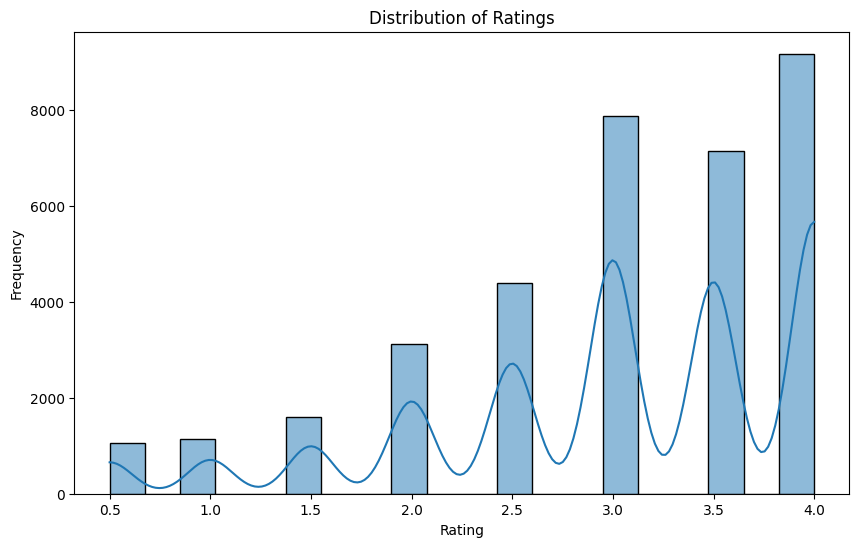

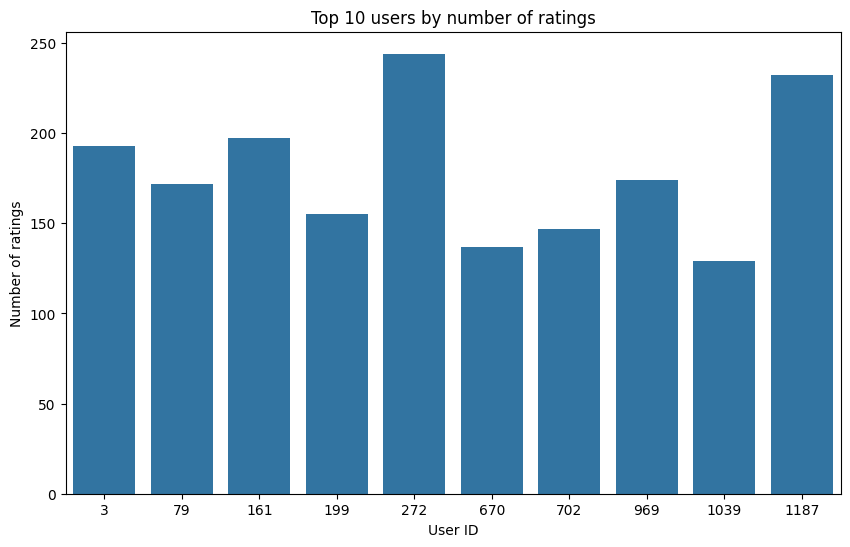

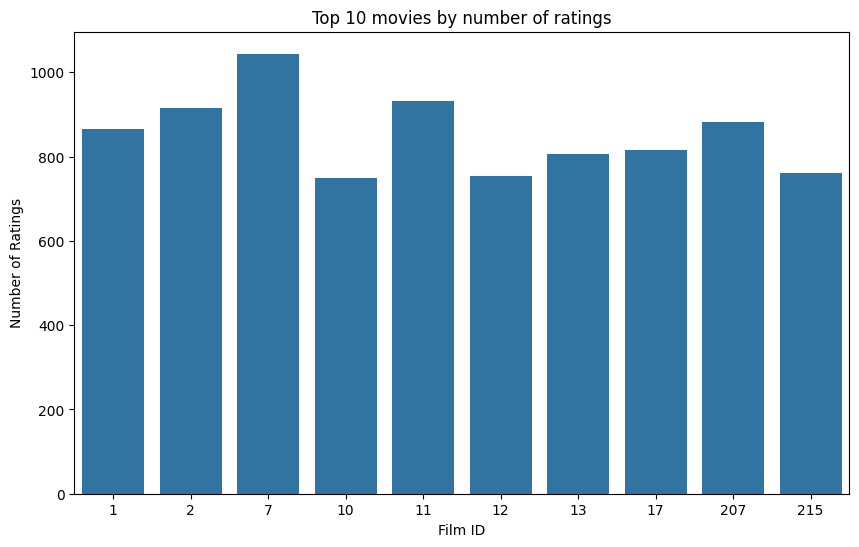


Trust Summary:
           Trustor      Trustee  Trust_Value
count  1853.000000  1853.000000       1853.0
mean    775.437669   782.192121          1.0
std     447.736536   471.614626          0.0
min       2.000000     2.000000          1.0
25%     410.000000   395.000000          1.0
50%     752.000000   716.000000          1.0
75%    1160.000000  1187.000000          1.0
max    1641.000000  1642.000000          1.0


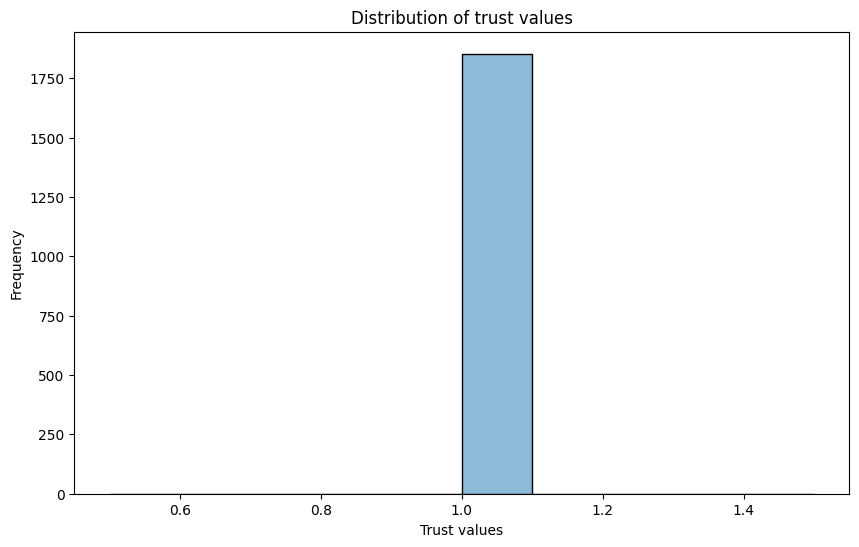

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#convert spark dataframes into pandas dataframes for seaborn
ratingspDF = ratingsDF.toPandas()
trustpDF = trustDF.toPandas()

#distribution of ratings
plt.figure(figsize=(10,6))
sns.histplot(ratingspDF['rating_value'], bins=20, kde=True)
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.show()

#top 10 users by number of ratings
topUsers = ratingspDF['userID'].value_counts().head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=topUsers.index, y=topUsers.values)
plt.title("Top 10 users by number of ratings")
plt.xlabel("User ID")
plt.ylabel("Number of ratings")
plt.show()

#top 10 films by number of ratings
topMovies = ratingspDF['FilmID'].value_counts().head(10)
plt.figure(figsize=(10,6))
sns.barplot(x=topMovies.index, y=topMovies.values)
plt.title("Top 10 movies by number of ratings")
plt.xlabel("Film ID")
plt.ylabel("Number of Ratings")
plt.show()

#summary statistics for trust data
trustSummary = trustpDF.describe()
print("\nTrust Summary:")
print(trustSummary)

#distribution of trust values
plt.figure(figsize=(10,6))
sns.histplot(trustpDF['Trust_Value'], bins=10, kde=True)
plt.title("Distribution of trust values")
plt.xlabel("Trust values")
plt.ylabel("Frequency")
plt.show()

In [7]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS

#split data into training and test sets
(trainingDF, testDF) = ratingsDF.randomSplit([0.8, 0.2], seed=42)

#initialise als model
als = ALS(
    maxIter=10,
    regParam=0.1,
    rank=10,
    userCol="userID",
    itemCol="FilmID",
    ratingCol="rating_value",
    coldStartStrategy="drop"
)

#training als model
alsModel = als.fit(trainingDF)

#make predictions on test data
predictions = alsModel.transform(testDF)
predictions.show(5)

#evaluation of model
evaluator = RegressionEvaluator(
    metricName = "rmse",
    labelCol = "rating_value",
    predictionCol = "prediction"
)

rmse = evaluator.evaluate(predictions)
print(f"Root mean squared error = {rmse}")

maeEvaluator = RegressionEvaluator(
    metricName = "mae",
    labelCol = "rating_value",
    predictionCol = "prediction"
)
mae = maeEvaluator.evaluate(predictions)
print(f"mean absolute error = {mae}")

#recommend top 5 films for each user
userRecommendations = alsModel.recommendForAllUsers(5)
userRecommendations.show(5)

#recommend 5 users for each film
filmRecommendations = alsModel.recommendForAllItems(5)
filmRecommendations.show(5)

+------+------+------------+----------+
|userID|FilmID|rating_value|prediction|
+------+------+------------+----------+
|  1214|   833|         4.0| 1.6056443|
|  1257|   463|         4.0| 3.4633844|
|  1297|  1829|         3.5|  1.308031|
|  1387|   496|         4.0| 2.9535828|
|   124|   243|         3.5|   2.19994|
+------+------+------------+----------+
only showing top 5 rows

Root mean squared error = 0.8685791101434495
mean absolute error = 0.6677409718049427
+------+--------------------+
|userID|     recommendations|
+------+--------------------+
|     1|[{68, 5.8682556},...|
|     3|[{68, 4.4817348},...|
|     5|[{208, 2.9219952}...|
|     6|[{68, 5.774644}, ...|
|     9|[{52, 4.2530484},...|
+------+--------------------+
only showing top 5 rows

+------+--------------------+
|FilmID|     recommendations|
+------+--------------------+
|     1|[{42, 4.342025}, ...|
|     3|[{42, 4.280171}, ...|
|     5|[{85, 4.0232673},...|
|     6|[{896, 3.7855086}...|
|    12|[{996, 3.9122956

In [19]:
import pandas as pd
from datetime import datetime
from geopy.distance import geodesic

#load datasets
passenger_data = pd.read_csv('AComp_Passenger_data_no_error.csv')
airport_data = pd.read_csv('Top30_airports_LatLong.csv')

#rename columns for clarity
passenger_data.columns = [
    "Passenger ID",
    "Flight ID",
    "From Airport",
    "Destination Airport",
    "Departure Time",
    "Total Flight Time"
]
airport_data.columns = [
    "Airport Name",
    "FAA Code",
    "Latitude",
    "Longitude"
]

#determine number of flights from each airport and list unused airports

#group passenger data by 'from airport' to count flights
flights_from_airports = passenger_data.groupby('From Airport').size().reset_index(name='Num_Flights')

#unused airports
used_airports = set(passenger_data['From Airport']).union(set(passenger_data['Destination Airport']))
all_airports = set(airport_data['FAA Code'])
unused_airports = all_airports - used_airports

#display results
print("\nNumber of flights form each airport")
print(flights_from_airports)

print("\nList of unused airports")
print(list(unused_airports))


#create a list of flights with details

#group by flight id to aggregate passenger and flight data
flights = passenger_data.groupby('Flight ID').agg({
    'Passenger ID': 'count',
    'From Airport': 'first',
    'Destination Airport': 'first',
    'Departure Time': 'first',
    'Total Flight Time': 'first'
}).reset_index()

#helper function to conver epoch time to HH:MM format
def convert_epoch_to_hhmm(epoch):
    try:
        return datetime.utcfromtimestamp(int(epoch)).strftime('%H:%M')
    except (ValueError, TypeError):
        return None

flights['Formatted Departure Time'] = flights['Departure Time'].apply(convert_epoch_to_hhmm)
flights['Formatted Arrival Time'] = flights.apply(
    lambda x: convert_epoch_to_hhmm(x['Departure Time'] + x['Total Flight Time'] * 60),
    axis=1
)

#rename and reorganise columns for clarity
flights = flights.rename(columns={
    'Passenger ID': 'Number of Passengers',
    'From Airport': 'Departure Airport',
    'Destination Airport': 'Arrival Airport'
})
flights = flights[['Flight ID', 'Number of Passengers', 'Departure Airport', 'Arrival Airport',
'Formatted Departure Time', 'Formatted Arrival Time']]

#print results
print("\nList of Flights with Details")

#calculate line-of-sight distance and total air miles for each passenger

#helper function to calculate distance between 2 airports
def calculate_distance(from_airport, to_airport):
    try:
        from_coords = airport_data.loc[airport_data['FAA Code'] == from_airport, ['Latitude', 'Longitude']].values[0]
        to_coords = airport_data.loc[airport_data['FAA Code'] == to_airport, ['Latitude', 'Longitude']].values[0]
        return geodesic(from_coords, to_coords).nautical
    except IndexError:
        return 0 #return 0 if airport not found

#add column for distance in passenger data
passenger_data['Distance (nautical miles)'] = passenger_data.apply(
    lambda x: calculate_distance(x['From Airport'], x['Destination Airport']),
    axis=1
)

#calculate total miles travelled by each passenger
passenger_miles = passenger_data.groupby('Passenger ID')['Distance (nautical miles)'].sum().reset_index()
passenger_miles = passenger_miles.rename(columns={'Distance (nautical miles)': 'Total Miles'})

#find passenger wit highest air miles
top_passenger = passenger_miles.loc[passenger_miles['Total Miles'].idxmax()]

#print results task 3
print("\nPassenger with the Higest Air Miles")
print(f"Passenger ID: {top_passenger['Passenger ID']}, Total Miles: {top_passenger['Total Miles']}")



Number of flights form each airport
   From Airport  Num_Flights
0           AMS           15
1           ATL           36
2           BKK           17
3           CAN           37
4           CDG           21
5           CGK           27
6           CLT           21
7           DEN           45
8           DFW           11
9           FCO           15
10          HND           13
11          IAH           37
12          JFK           25
13          KUL           33
14          LAS           17
15          LHR           25
16          MAD           13
17          MIA           11
18          MUC           14
19          ORD           33
20          PEK           13
21          PVG           20

List of unused airports
['PHX', 'IST']

List of Flights with Details


C:\Users\Student\AppData\Local\Temp\ipykernel_5464\692790752.py:57: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  return datetime.utcfromtimestamp(int(epoch)).strftime('%H:%M')
C:\Users\Student\AppData\Local\Temp\ipykernel_5464\692790752.py:57: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  return datetime.utcfromtimestamp(int(epoch)).strftime('%H:%M')



Passenger with the Higest Air Miles
Passenger ID: BWI0520BG6, Total Miles: 124942.55951828713
